## TASK 1

## Dataset Overview

We begin by loading the breast cancer dataset and inspecting its structure. 

In [17]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

import sys
import os

print(sys.path)


['/home/asimenia/Assignment-2/notebooks', '/home/asimenia/anaconda3/lib/python312.zip', '/home/asimenia/anaconda3/lib/python3.12', '/home/asimenia/anaconda3/lib/python3.12/lib-dynload', '', '/home/asimenia/anaconda3/lib/python3.12/site-packages', '/home/asimenia/anaconda3/lib/python3.12/site-packages/setuptools/_vendor', '/home/asimenia/Assignment-2/src', '/home/asimenia/Assignment-2/src', '/home/asimenia/Assignment-2/src', '/home/asimenia/Assignment-2']


In [18]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA


import sys
sys.path.append('/home/asimenia/Assignment-2/src')

from data_loader import load_data
from preprocessing import preprocess_data
from utils import basic_overview, class_distribution




# Set plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


df = load_data("/home/asimenia/Assignment-2/data/breast_cancer.csv")
basic_overview(df)
df = preprocess_data(df)
class_distribution(df)

Shape of dataset: (512, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       512 non-null    int64  
 1   diagnosis                512 non-null    object 
 2   radius_mean              505 non-null    float64
 3   texture_mean             507 non-null    float64
 4   perimeter_mean           507 non-null    float64
 5   area_mean                508 non-null    float64
 6   smoothness_mean          506 non-null    float64
 7   compactness_mean         511 non-null    float64
 8   concavity_mean           502 non-null    float64
 9   concave points_mean      504 non-null    float64
 10  symmetry_mean            507 non-null    float64
 11  fractal_dimension_mean   509 non-null    float64
 12  radius_se                510 non-null    float64
 13  texture_se               505 non-null    float64
 14

## Descriptive Statistics

The dataset has 512 rows and 32 columns, including the diagnosis target. The statistical summary reveals that all 30 features are numerical. The missing values are adressed later on, generally the data appears clean. The diagnosis column is categorical, indicating benign (B) or malignant (M) tumors.


## Class Balance

Here we assess class distribution for the binary target variable. The plot shows that the dataset is a little imbalanced, with more benign than malignant samples. This will influence how we perform cross-validation and metric selection later.


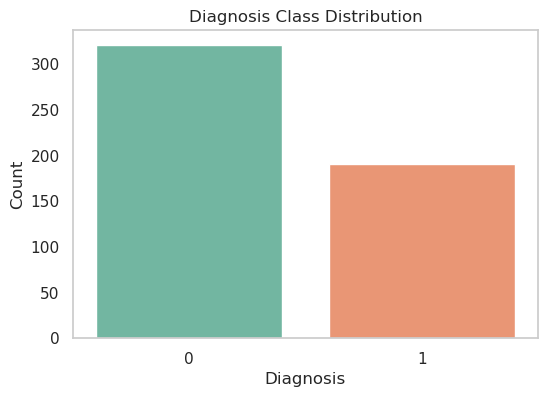

Class Counts:
 diagnosis
0    321
1    191
Name: count, dtype: int64

Class Percentages:
 diagnosis
0    62.695312
1    37.304688
Name: count, dtype: float64


In [19]:
# Countplot for diagnosis classes
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='diagnosis', palette='Set2')
plt.title('Diagnosis Class Distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

# Print the exact class counts and percentages
class_counts = df['diagnosis'].value_counts()
print("Class Counts:\n", class_counts)
print("\nClass Percentages:\n", class_counts / len(df) * 100)


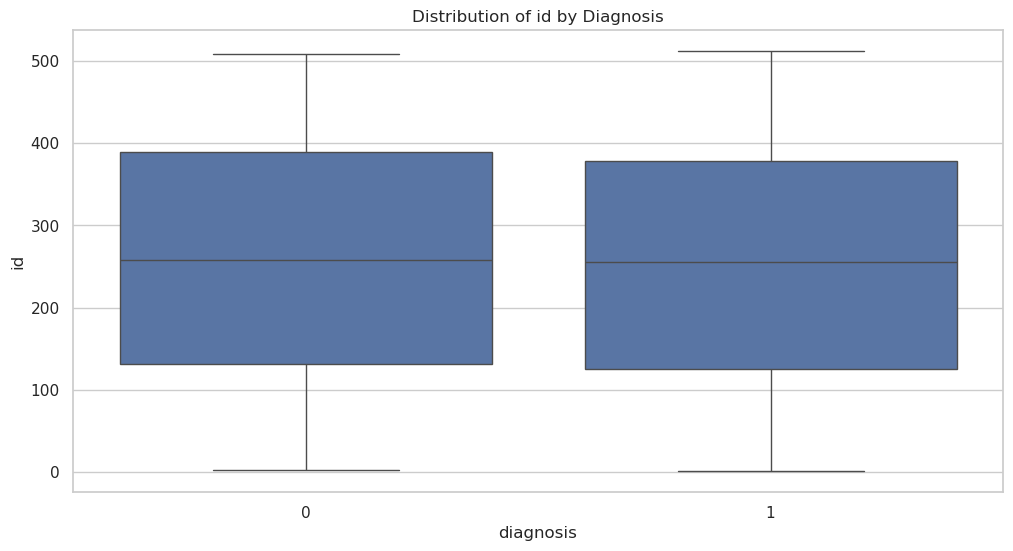

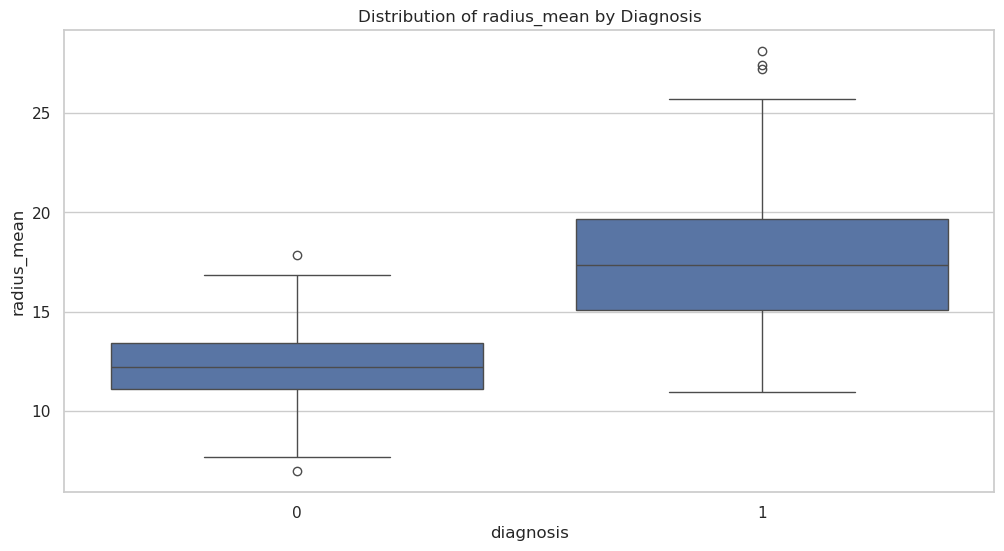

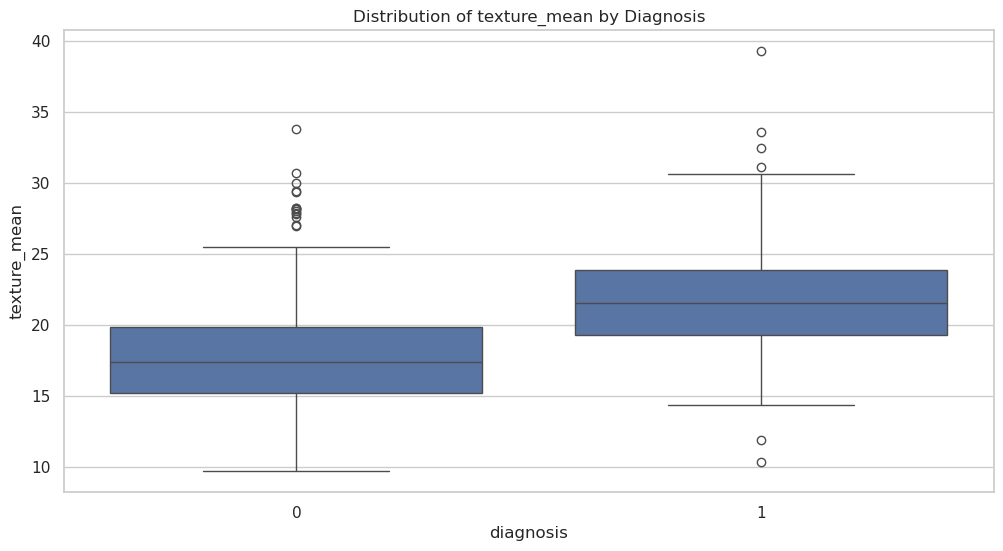

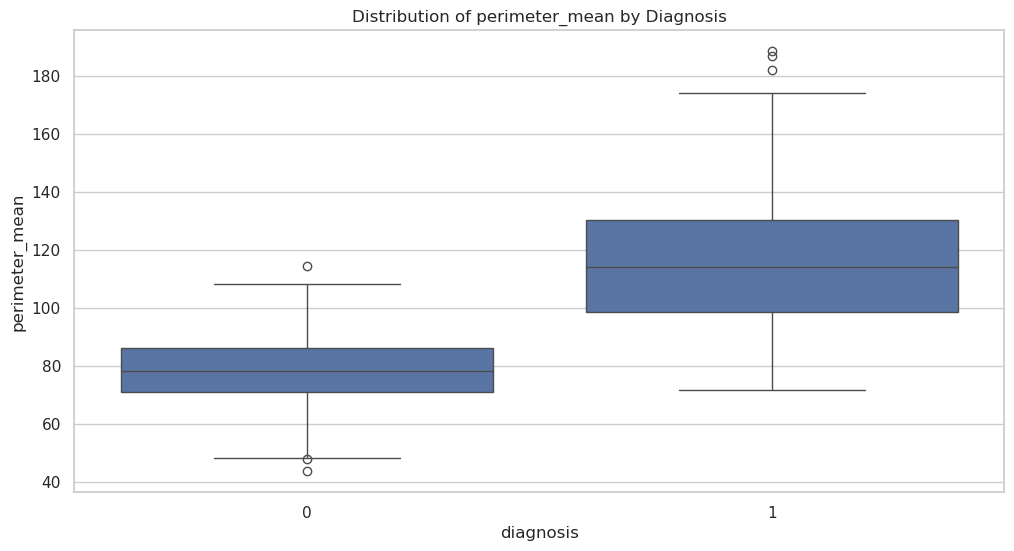

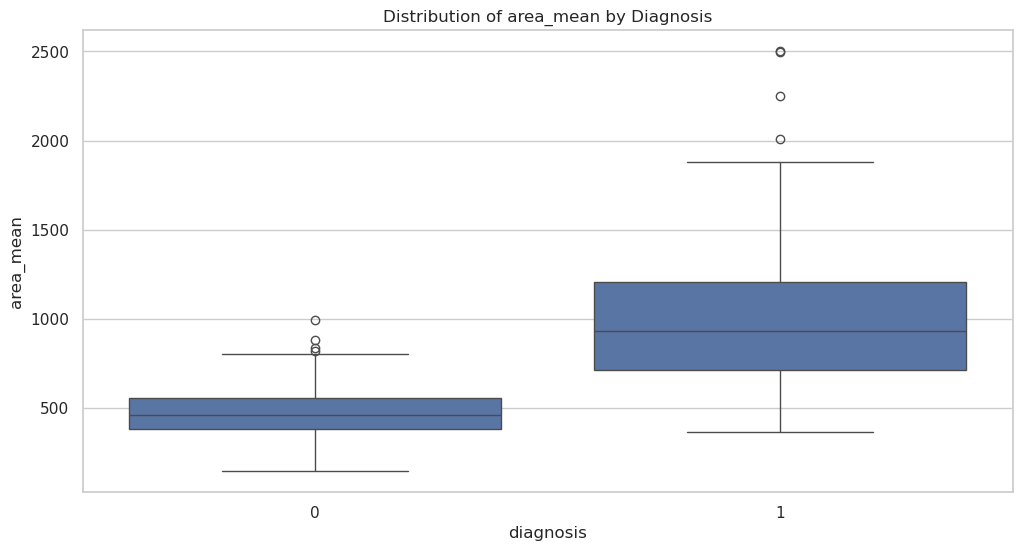

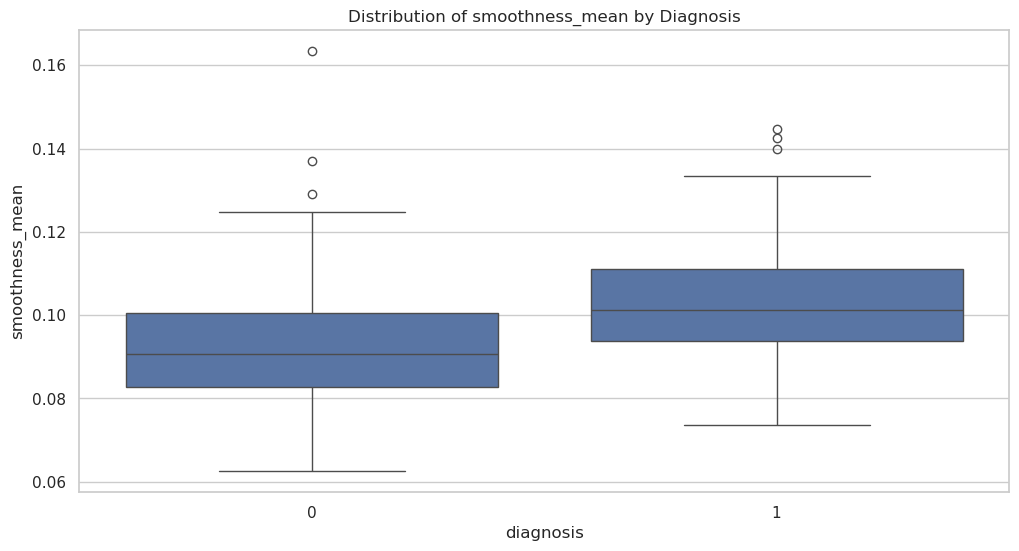

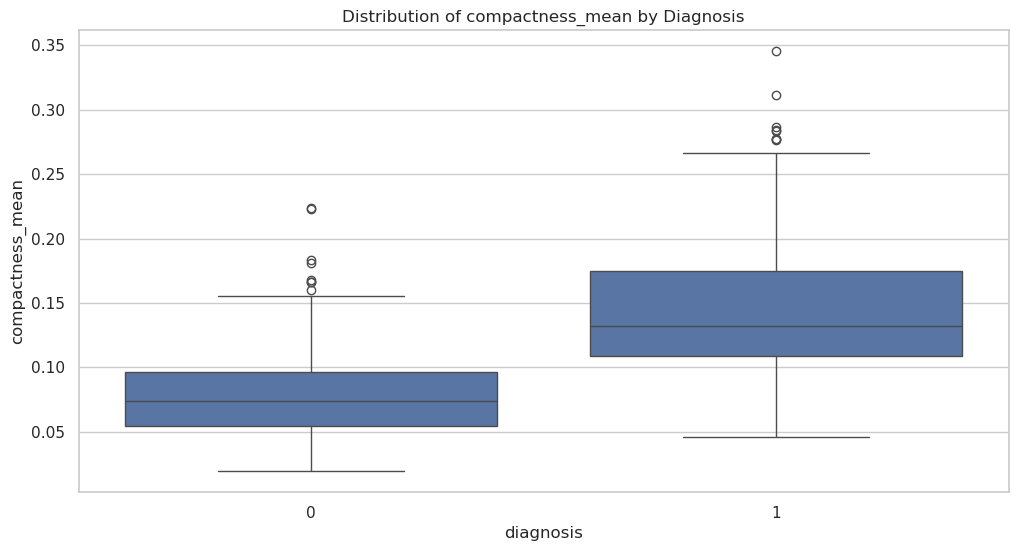

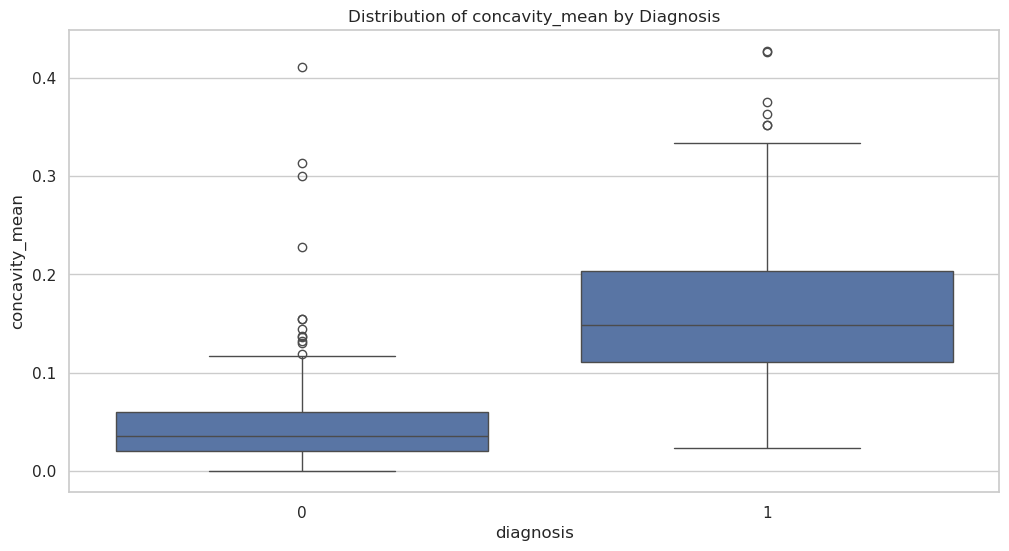

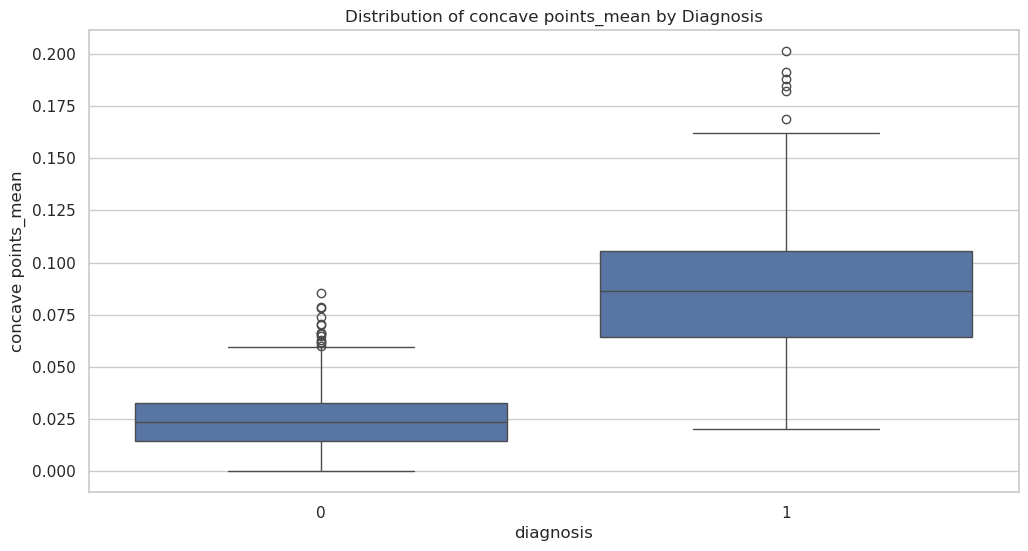

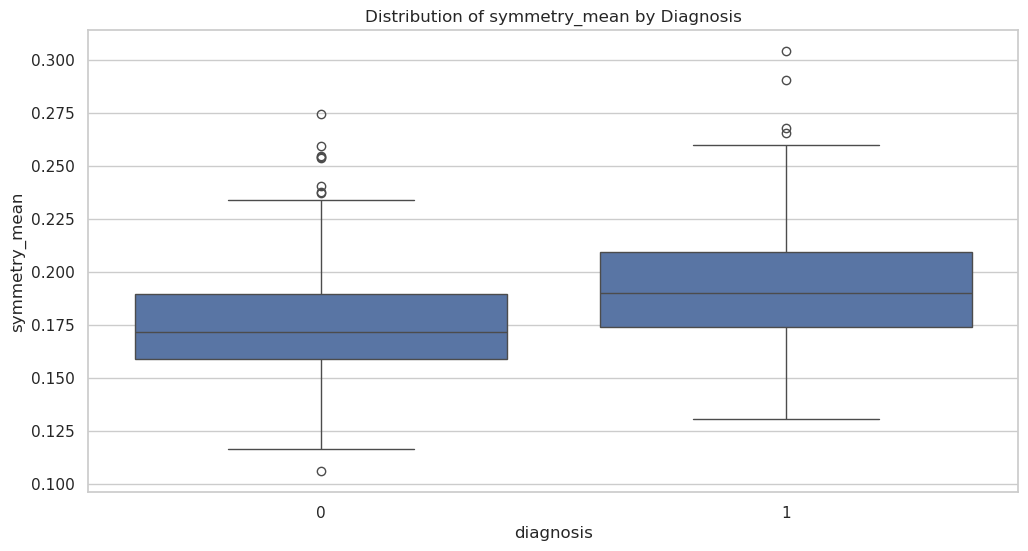

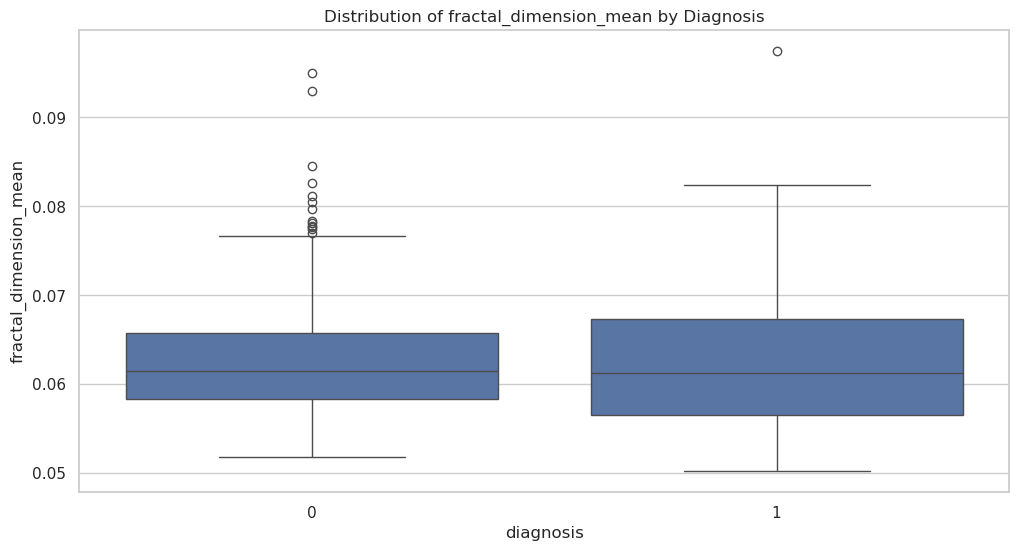

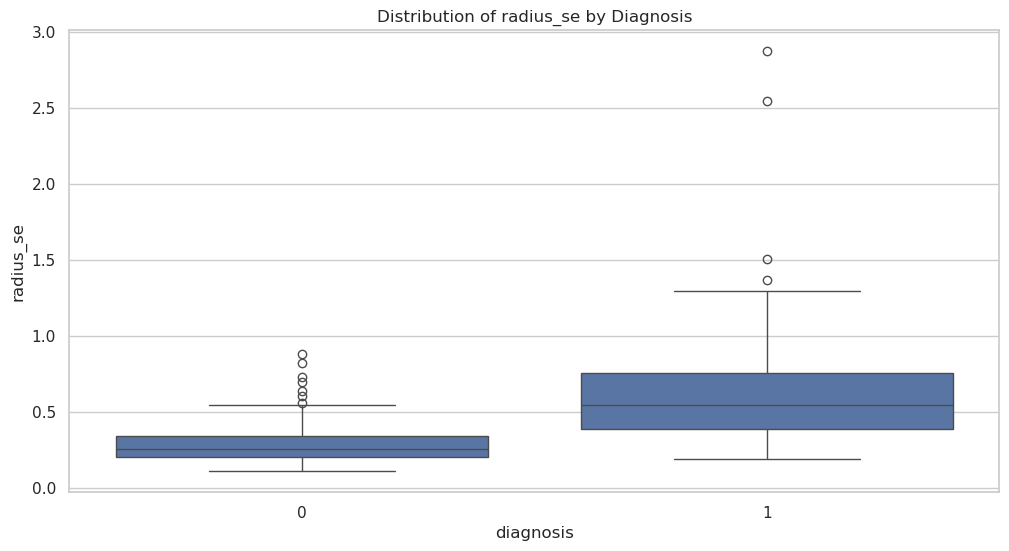

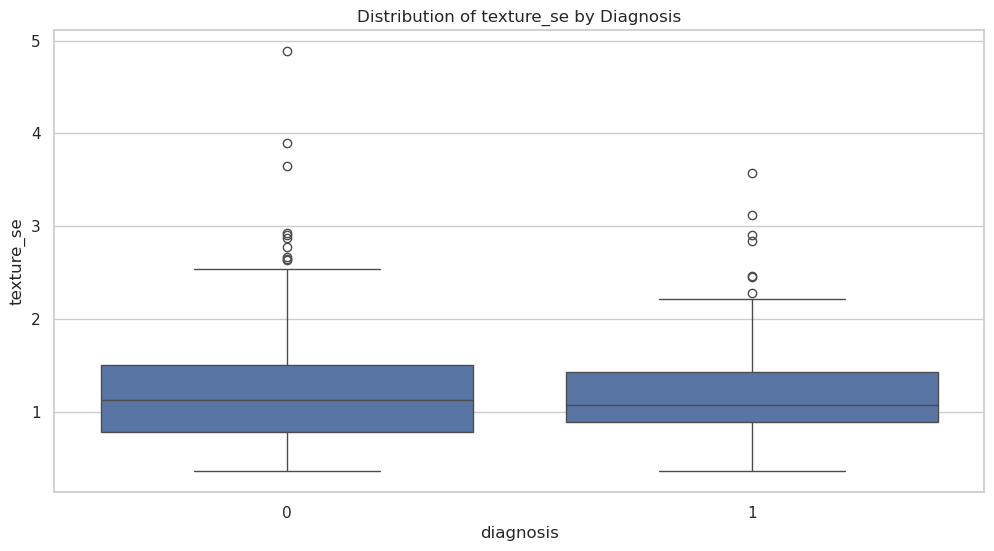

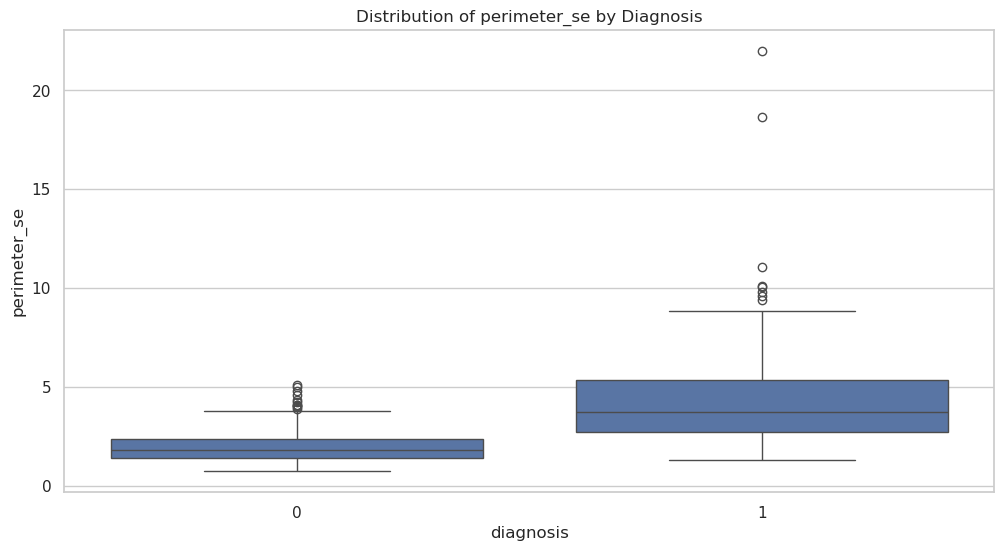

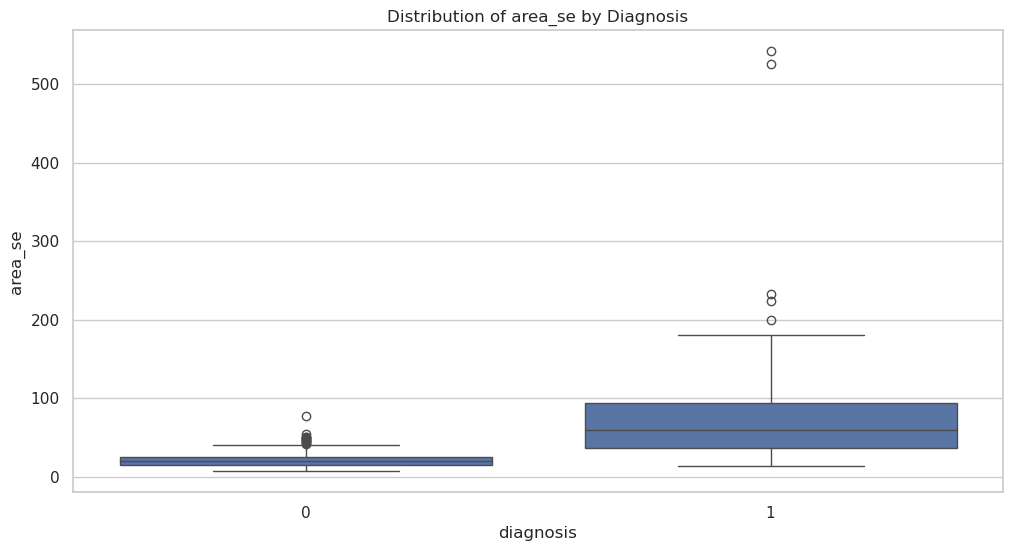

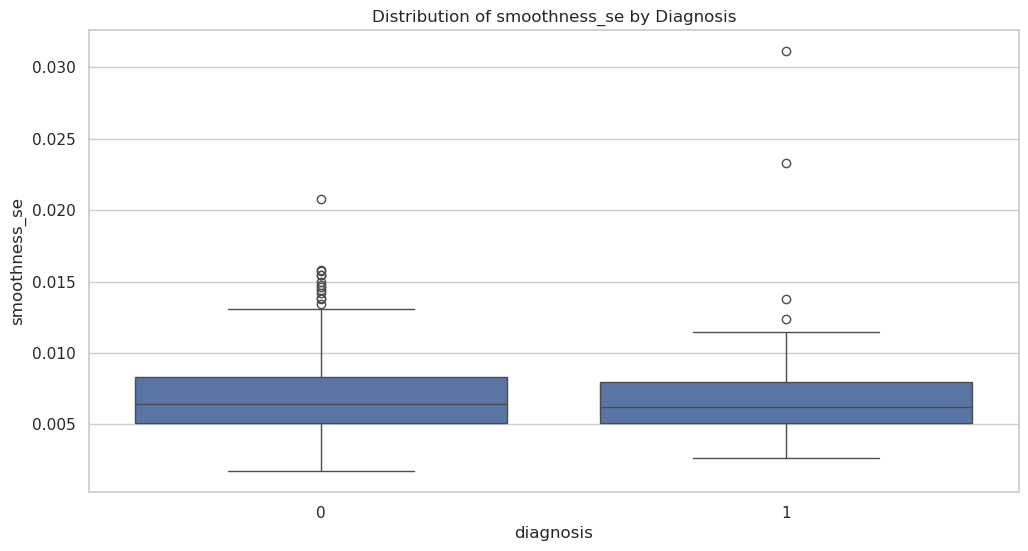

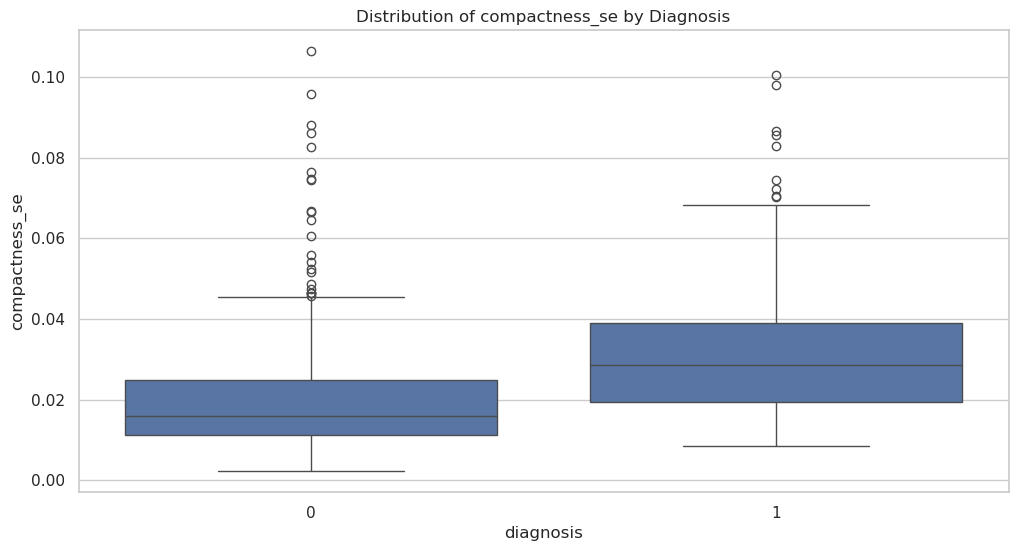

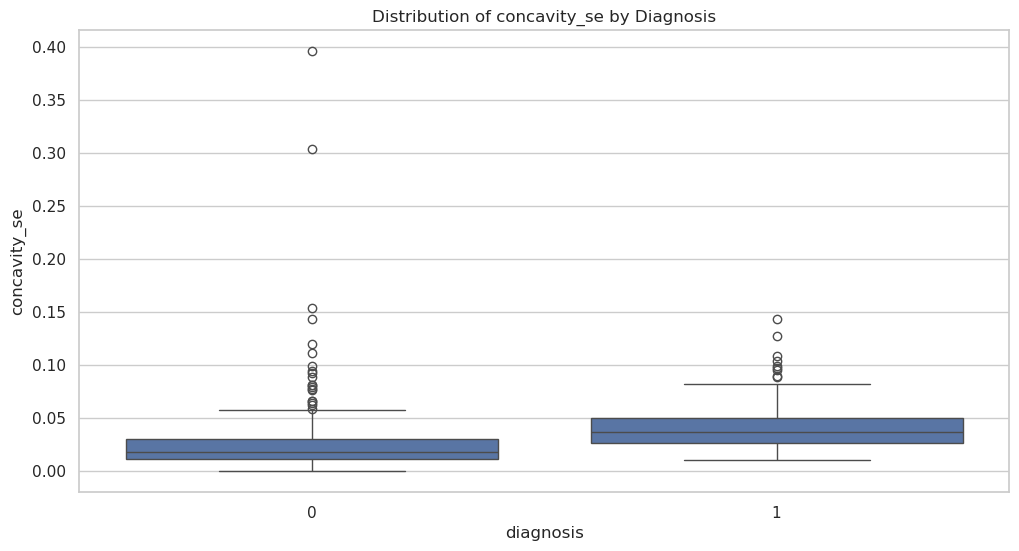

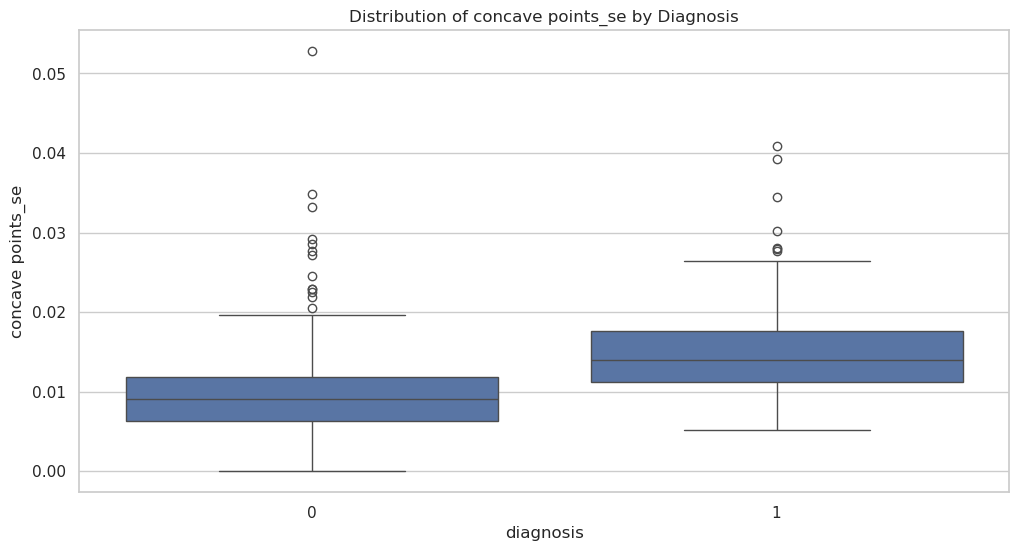

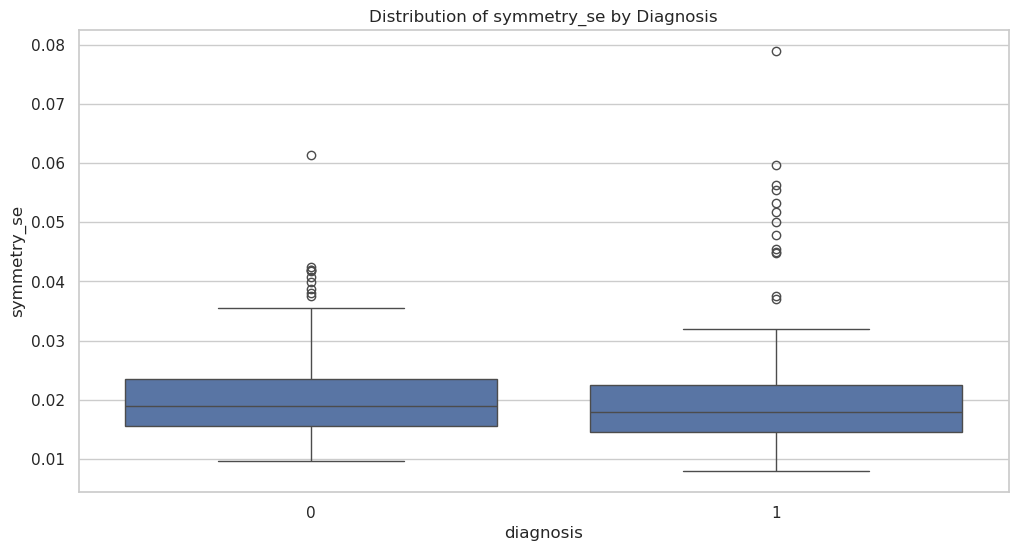

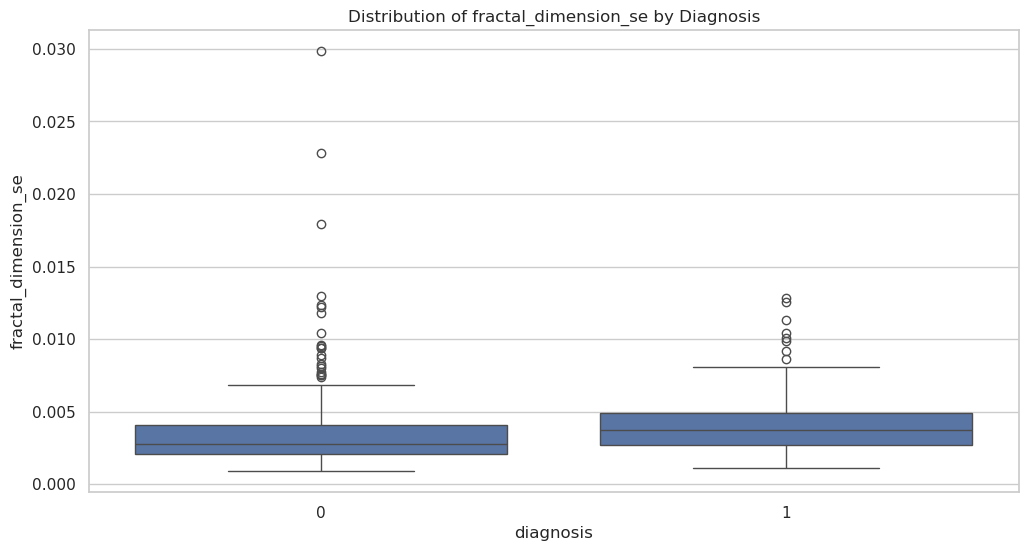

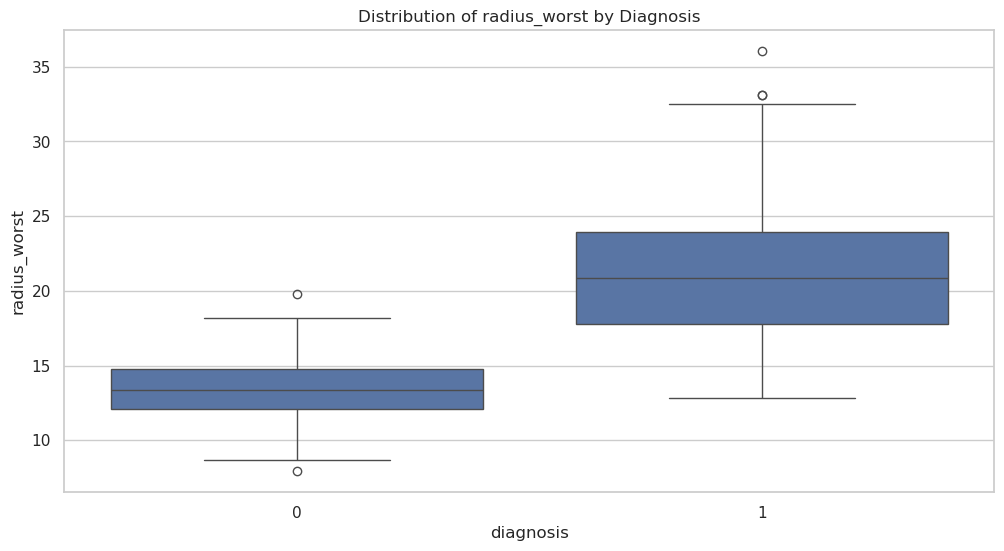

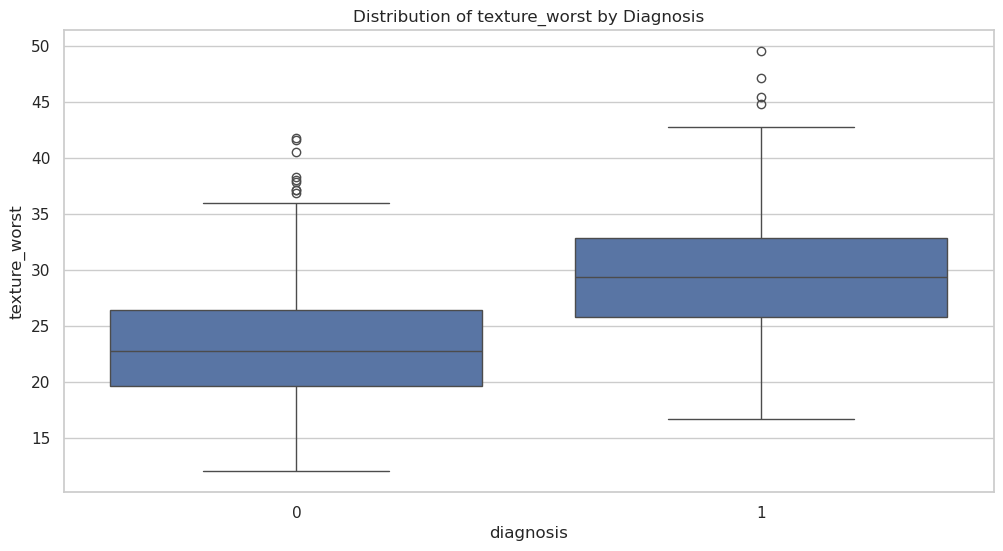

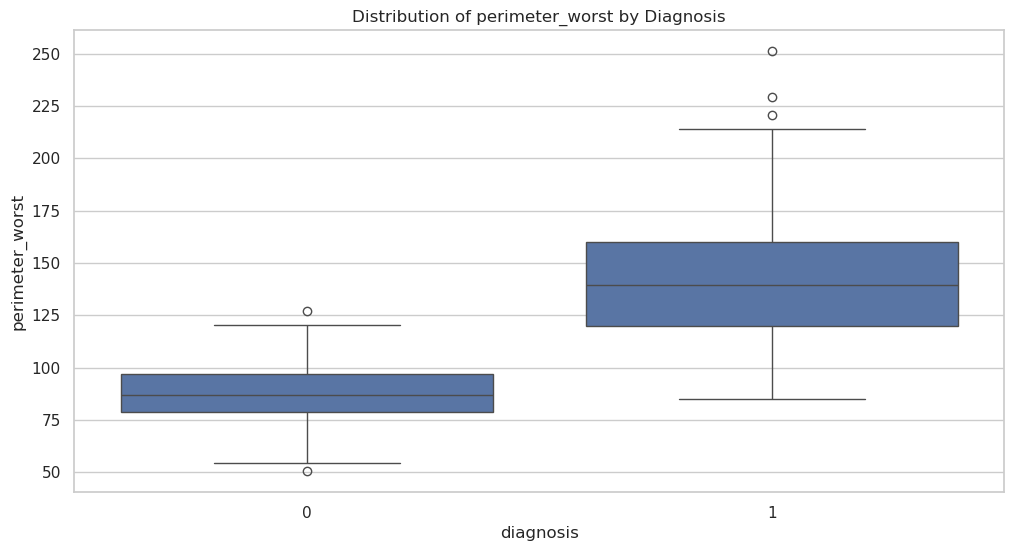

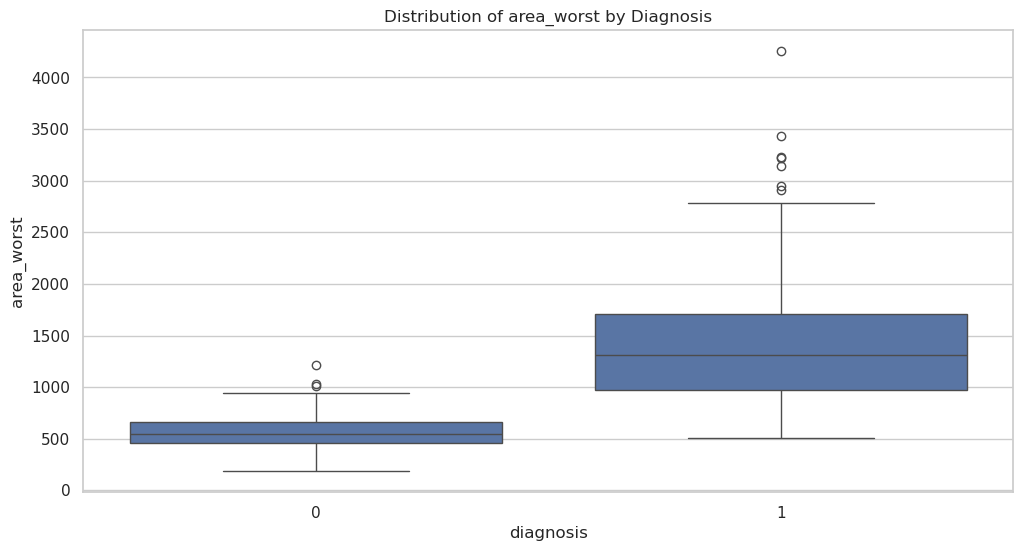

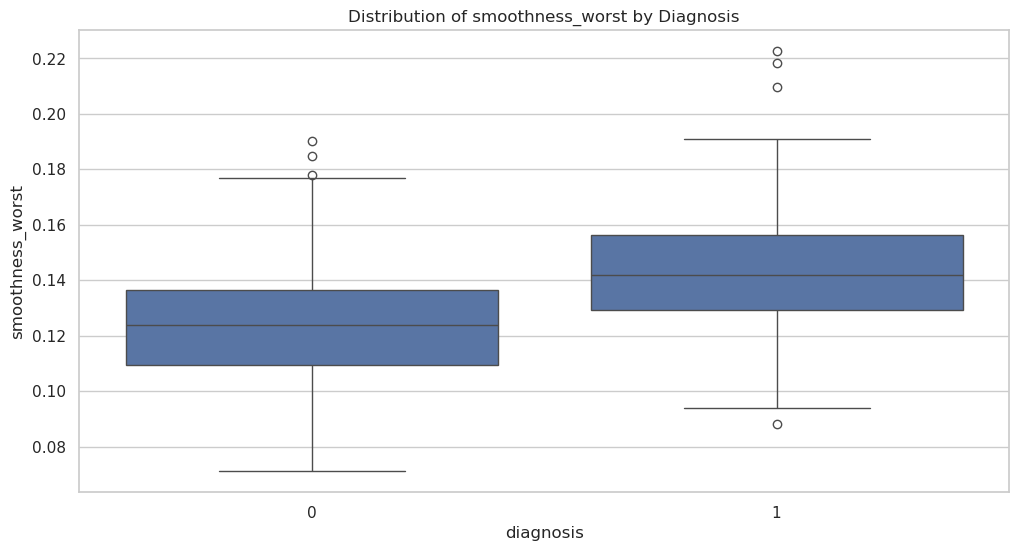

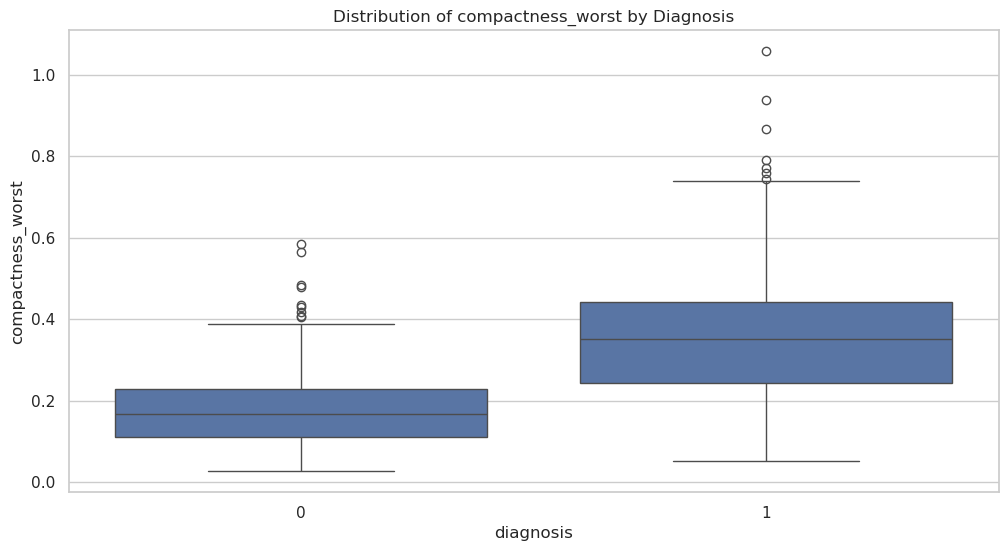

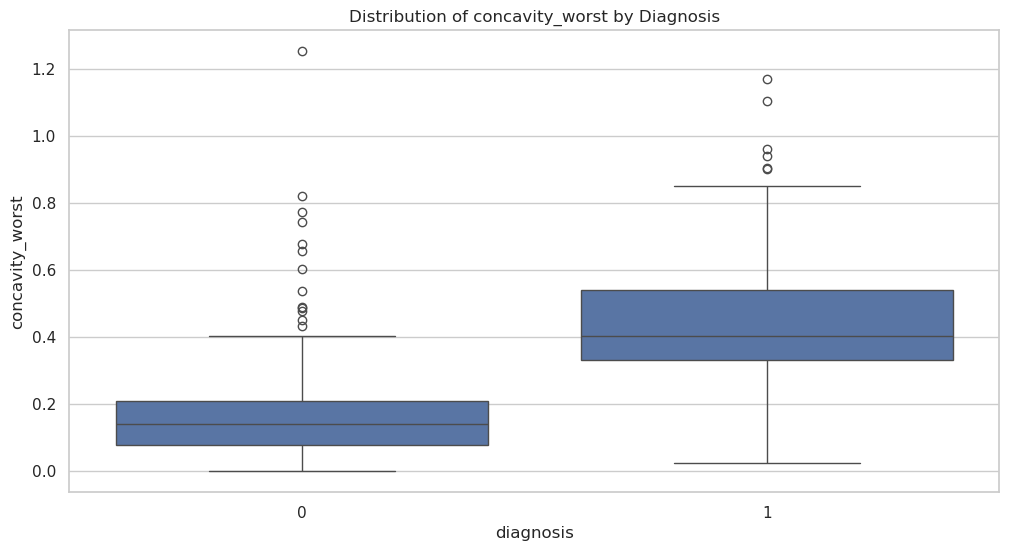

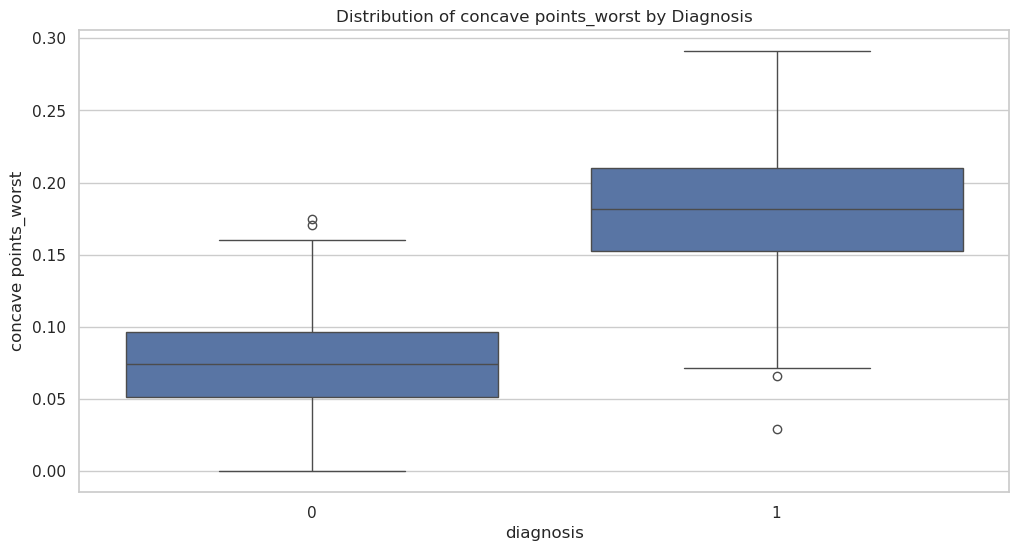

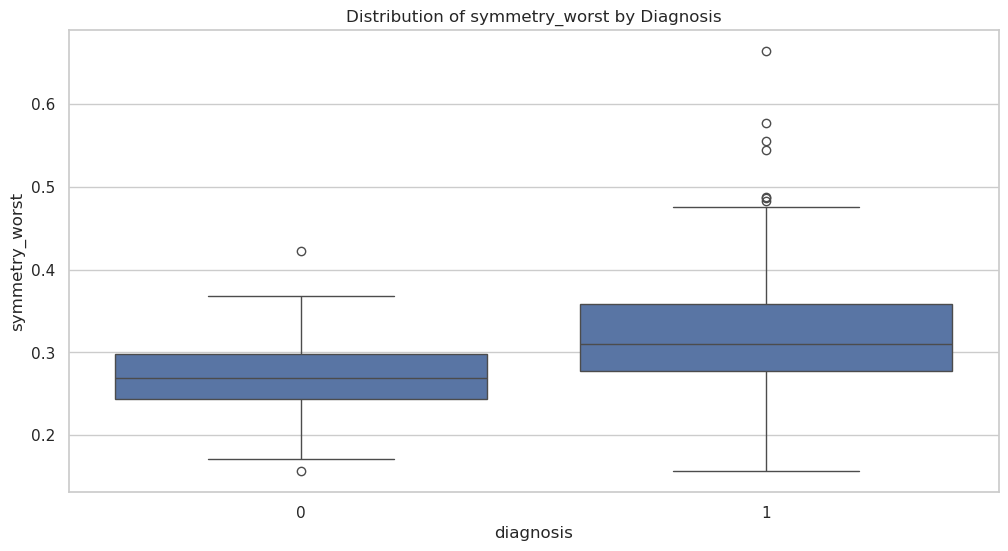

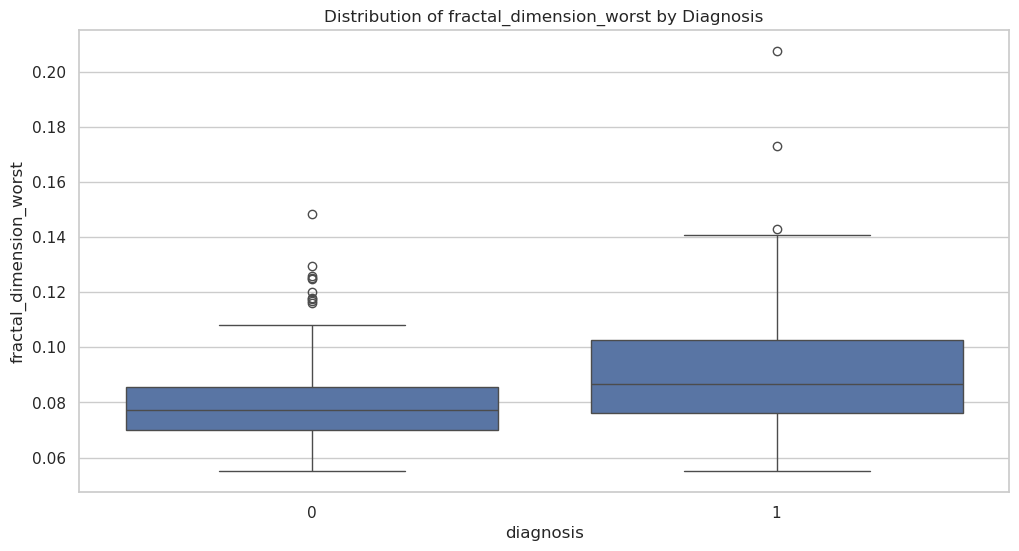

In [20]:
# Descriptive statistics
df.describe()

# Box plots for each feature grouped by diagnosis
for col in df.columns:
    if col != 'diagnosis':
        plt.figure()
        sns.boxplot(data=df, x='diagnosis', y=col)
        plt.title(f'Distribution of {col} by Diagnosis')
        plt.show()


## Feature Correlation Analysis

The heatmap highligths several groups of features with strong correlations, indicating redundancy. For example, radius_mean, perimeter_mean, and area_mean are highly correlated. 


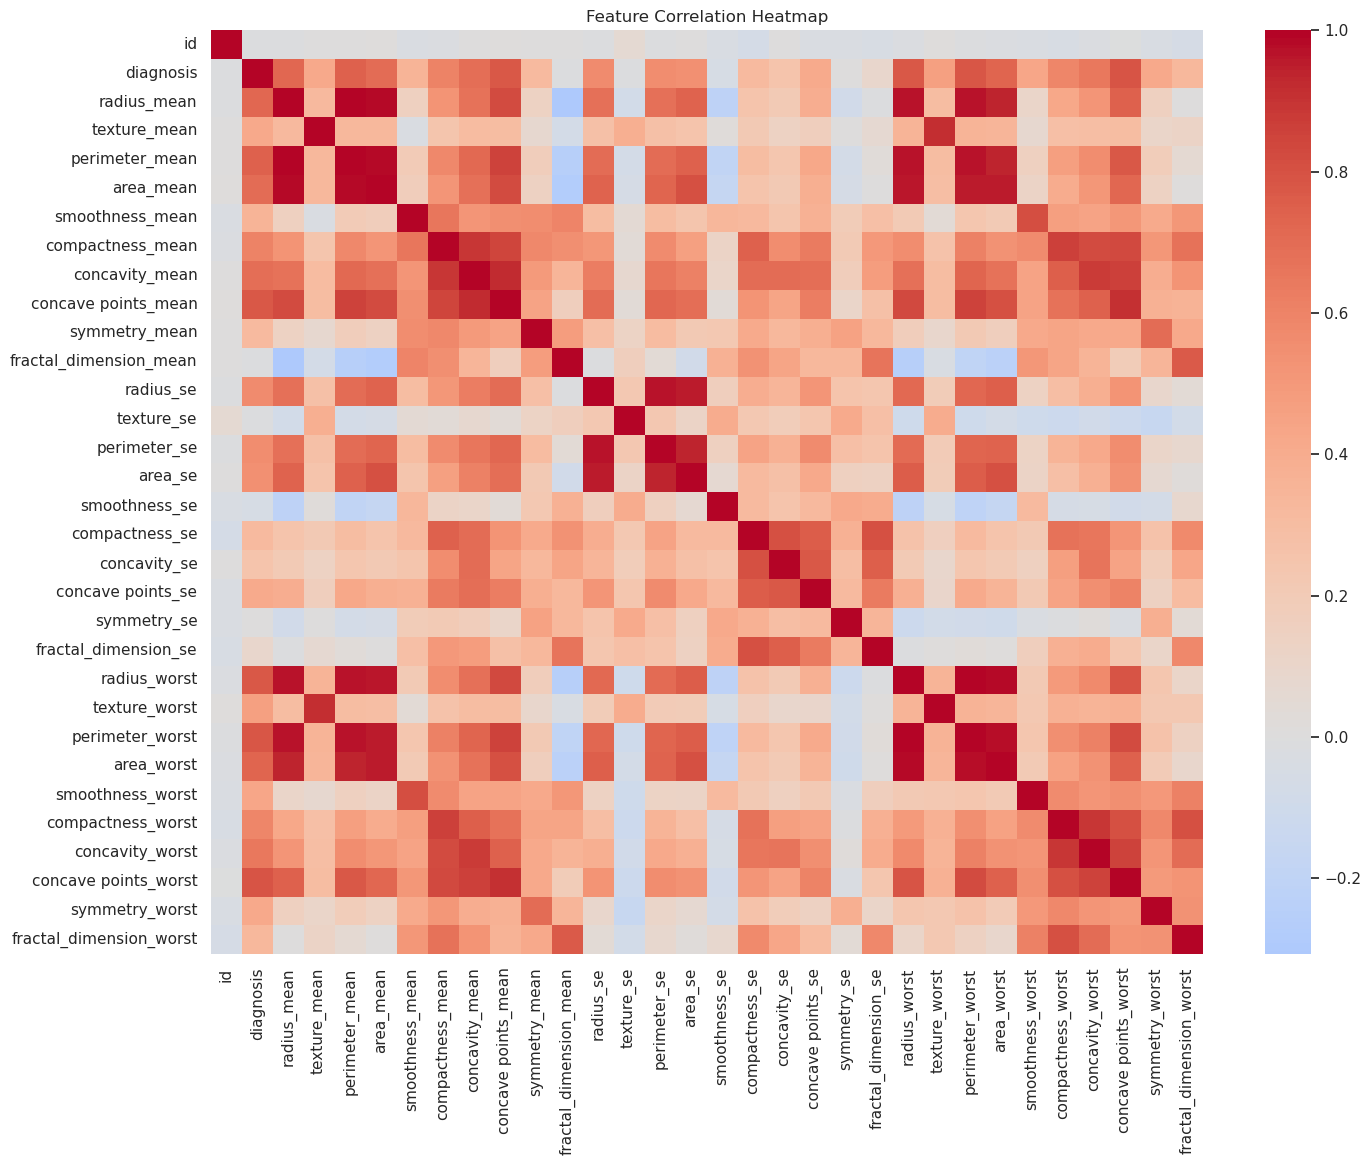

In [21]:
# Correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


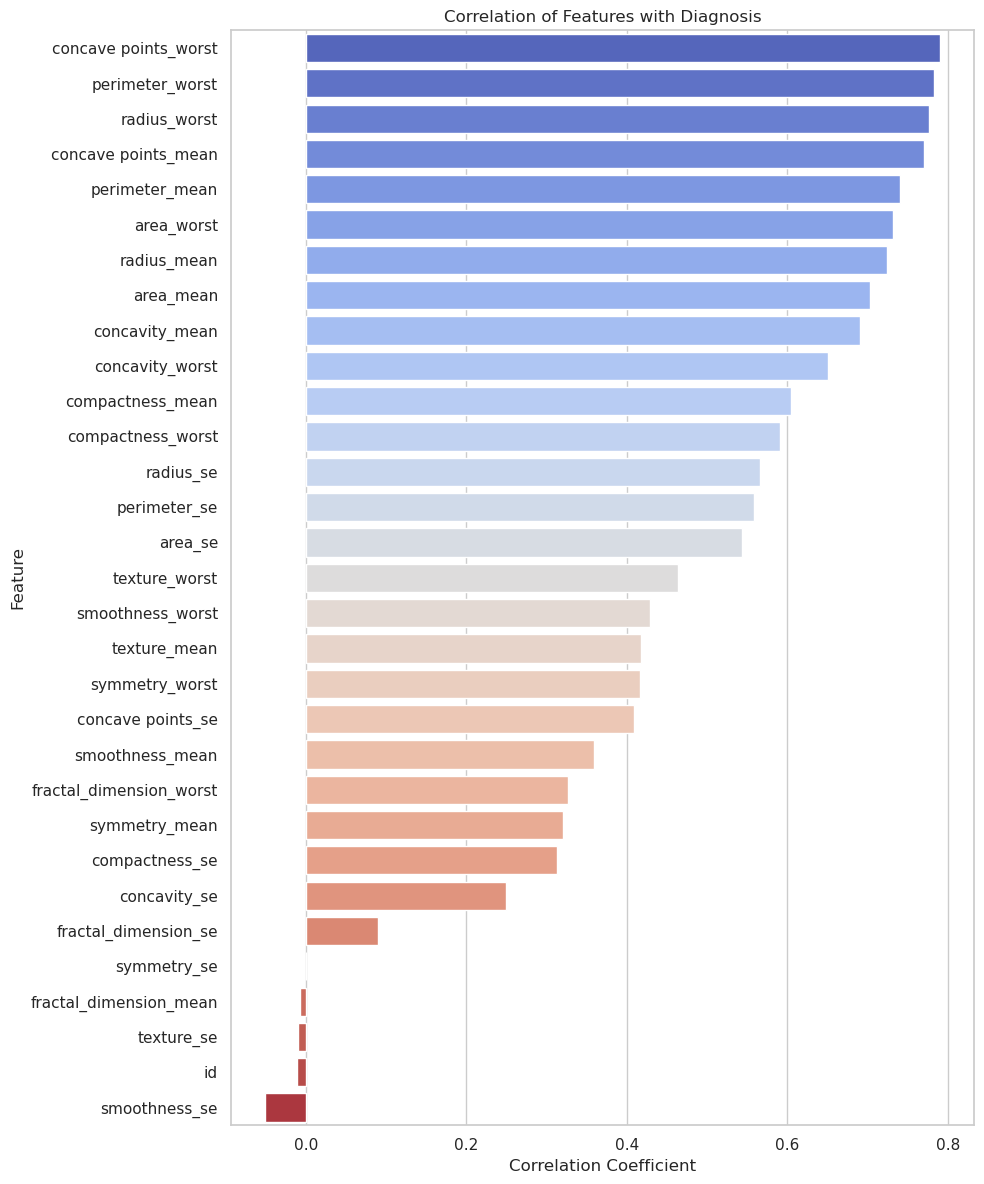

In [22]:
# Correlation of each feature with diagnosis specifically
diag_corr = df.corr()['diagnosis'].drop('diagnosis').sort_values(ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(x=diag_corr.values, y=diag_corr.index, palette='coolwarm')
plt.title("Correlation of Features with Diagnosis")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Principal Component Analysis (PCA)

PCA reveals the separability of malignant and benign tumors in reduced dimensions. The first two principal components show decent class separation, suggesting that the data is linearly separable to some extent. The explained variance plot confirms that a few components capture most of the variance in the dataset.


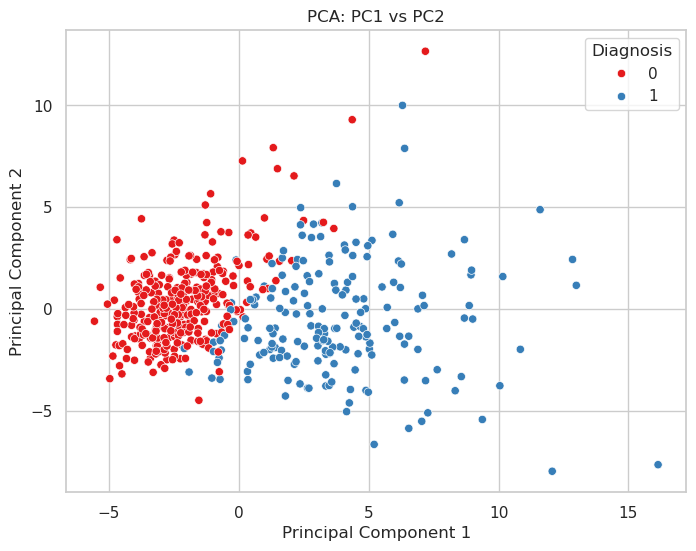

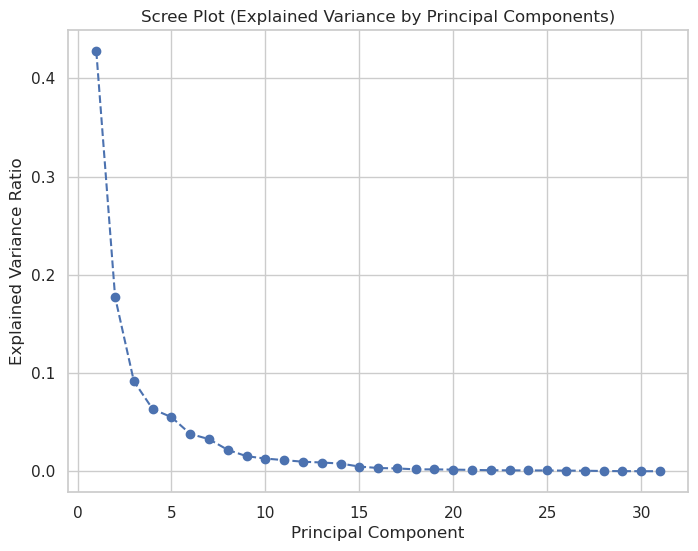

In [23]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Drop the target column for PCA
features = df.drop(columns=['diagnosis'])

# Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

# Scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Diagnosis'] = df['diagnosis'].values

# Plot PCA result
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Diagnosis', palette='Set1')
plt.title('PCA: PC1 vs PC2')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Scree plot
explained_variance = PCA().fit(features_scaled).explained_variance_ratio_
plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', linestyle='--')
plt.title('Scree Plot (Explained Variance by Principal Components)')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()


## TASK 3

## Repeated Nested Cross-Validation (rnCV) Class Design

To systematically evaluate model generalization, we implement a fully object-oriented pipeline for repeated nested cross-validation. This allows us to avoid data leakage, tune hyperparameters, and estimate unbiased performance metrics.

The class is parameterized by:
- Dataset
- Classifiers and their hyperparameter grids
- Number of outer (N=5) and inner (K=3) folds
- Number of repetitions (R=10)

Stratified folds ensure class balance is maintained throughout the CV process.


In [24]:
import sys
sys.path.append('/home/asimenia/Assignment-2')


from repeated_nested_cv import RepeatedNestedCV


In [25]:
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer


# Assuming df is your cleaned DataFrame
X = df.drop(columns=["diagnosis"]).values
y = df["diagnosis"].values


## Classifier Setup and Hyperparameter Grids

We evaluate six classification algorithms:
- Logistic Regression (Elastic Net)
- Gaussian Naive Bayes
- Linear Discriminant Analysis
- Support Vector Machine
- Random Forest
- LightGBM

Each model is provided with a dedicated hyperparameter grid for optimization during inner-loop CV. The inner loop selects optimal hyperparameters based on performance on validation folds.

This is where missing values are handled with SimpleImputer


In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Pipelines with imputation and scaling where needed
estimators = {
    'SVM': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('clf', SVC(probability=True, class_weight='balanced'))
    ]),
    'RF': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('clf', RandomForestClassifier(class_weight='balanced'))
    ]),
    'LR': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            penalty='elasticnet',
            solver='saga',
            class_weight='balanced',
            max_iter=5000
        ))
    ]),
}

# Define hyperparameter grids
param_grids = {
    'SVM': {
        'clf__C': [0.1, 1, 10],
        'clf__gamma': ['scale', 'auto']
    },
    'RF': {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [5, 10]
    },
    'LR': {
        'clf__C': [0.1, 1, 10],
        'clf__l1_ratio': [0.2, 0.5, 0.8]
    }
}


In [27]:
cv_runner = RepeatedNestedCV(estimators, param_grids, R=10, N=5, K=3)
results_df = cv_runner.run(X, y)



In [28]:
print(results_df.head())  
print(results_df.describe())  
print(results_df['estimator'].value_counts())  # How many runs per model


         F1        F2        BA  Precision    Recall       MCC       AUC  \
0  0.962963  0.984848  0.976562   0.928571  1.000000  0.940768  0.998798   
1  0.961039  0.953608  0.966546   0.973684  0.948718  0.937991  0.996394   
2  1.000000  1.000000  1.000000   1.000000  1.000000  1.000000  1.000000   
3  0.933333  0.925926  0.945142   0.945946  0.921053  0.895373  0.987854   
4  0.897436  0.911458  0.922065   0.875000  0.921053  0.835713  0.956680   

  estimator  round  
0       SVM      0  
1        RF      0  
2        LR      0  
3       SVM      0  
4        RF      0  
               F1          F2          BA   Precision      Recall         MCC  \
count  150.000000  150.000000  150.000000  150.000000  150.000000  150.000000   
mean     0.951925    0.948255    0.960770    0.959092    0.946050    0.924565   
std      0.025626    0.033123    0.021790    0.028257    0.039774    0.039466   
min      0.869565    0.819672    0.886924    0.871795    0.789474    0.812447   
25%      0.9

Average performance per model:
                 F1        F2        BA  Precision    Recall       MCC  \
estimator                                                                
LR         0.962399  0.958460  0.968965   0.969635  0.955992  0.940916   
RF         0.935887  0.929161  0.947265   0.948850  0.925074  0.899943   
SVM        0.957488  0.957143  0.966079   0.958792  0.957085  0.932836   

                AUC  round  
estimator                   
LR         0.992381    4.5  
RF         0.987657    4.5  
SVM        0.992956    4.5  
                 F1        F2        BA  Precision    Recall       MCC  \
estimator                                                                
LR         0.962399  0.958460  0.968965   0.969635  0.955992  0.940916   
SVM        0.957488  0.957143  0.966079   0.958792  0.957085  0.932836   
RF         0.935887  0.929161  0.947265   0.948850  0.925074  0.899943   

                AUC  round  
estimator                   
LR         0.992381    4

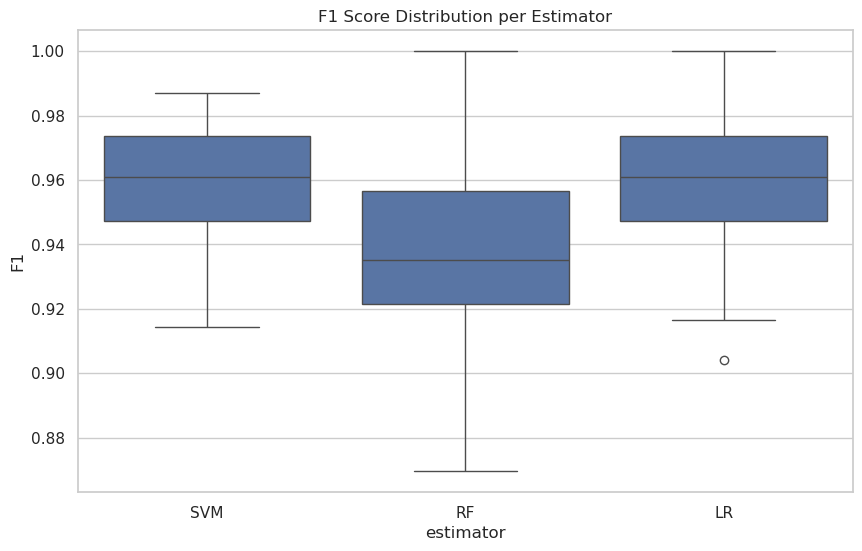

In [29]:
avg_scores = results_df.groupby('estimator').mean(numeric_only=True)
print("Average performance per model:")
print(avg_scores)


print(avg_scores.sort_values(by='F1', ascending=False))  # Sort by F1 score

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(data=results_df, x="estimator", y="F1")
plt.title("F1 Score Distribution per Estimator")
plt.show()



## Winner Model Selection

Based on median performance across all repetitions, we select the model that achieves the most consistent and highest scores in AUC and MCC. The winner is Logistic Regression.

LR ties with SVM in F1_median (both = 0.961039), but, LR has slightly higher MCC (0.9380 vs. 0.9376) and slightly higher AUC (0.9949 vs. 0.9945). LR has also slightly lower IQRs (more consistent performance).


In [30]:
#  Compute median and IQR for each metric per estimator
grouped = results_df.groupby('estimator')

# Important metrics
metrics = ['F1', 'MCC', 'AUC']

median_scores = grouped[metrics].median().rename(columns=lambda c: c + '_median')
iqr_scores = (grouped[metrics].quantile(0.75) - grouped[metrics].quantile(0.25)) \
              .rename(columns=lambda c: c + '_IQR')

summary = median_scores.join(iqr_scores)
print("Median and IQR per model:")
print(summary)

# 2) Sort by median F1
winner = summary.sort_values(by='F1_median', ascending=False).head(1)
print("\n Winning model based on median F1:")
print(winner)


Median and IQR per model:
           F1_median  MCC_median  AUC_median    F1_IQR   MCC_IQR   AUC_IQR
estimator                                                                 
LR          0.961039    0.937991    0.994929  0.026316  0.042380  0.008018
RF          0.935065    0.895900    0.990870  0.035119  0.057248  0.015566
SVM         0.961039    0.937627    0.994523  0.026316  0.042307  0.009209

 Winning model based on median F1:
           F1_median  MCC_median  AUC_median    F1_IQR  MCC_IQR   AUC_IQR
estimator                                                                
LR          0.961039    0.937991    0.994929  0.026316  0.04238  0.008018


In [31]:
best_f1_per_model = results_df.loc[results_df.groupby('estimator')['F1'].idxmax()]
print("Best performing round per model:")
print(best_f1_per_model[['estimator', 'F1', 'MCC', 'AUC']])


Best performing round per model:
   estimator        F1       MCC  AUC
2         LR  1.000000  1.000000  1.0
19        RF  1.000000  1.000000  1.0
18       SVM  0.987013  0.979474  1.0


## Task 4

## Final Model Hyperparameter Tuning (CV(5))

Using the winning algorithm from rnCV, we now perform 5-fold cross-validation on the entire dataset to identify the best combination of hyperparameters. This allows us to fine-tune the model using all available data.


In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Re-create best estimator pipeline
final_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=5000))
])

# Re-use LR's param grid
param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__l1_ratio': [0.2, 0.5, 0.8]
}

# GridSearchCV with 5-fold CV
grid = GridSearchCV(final_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X, y)

print("Best params:", grid.best_params_)


Best params: {'clf__C': 0.1, 'clf__l1_ratio': 0.2}


In [33]:
# Set the pipeline with best params
best_final_model = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        C=grid.best_params_['clf__C'],
        l1_ratio=grid.best_params_['clf__l1_ratio'],
        max_iter=1000
    ))
])

# Fit to the entire dataset
best_final_model.fit(X, y)


Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=0.1, l1_ratio=0.2, max_iter=1000,
                                    penalty='elasticnet', solver='saga'))])

## Final Model Training and Export

Using the best hyperparameters from the GridSearchCV step, we retrain the final model on the full dataset. The trained pipeline, which includes imputation and scaling, is then serialized and saved to the `./models` directory for deployment. This model is now ready to be used on new unseen samples.


In [34]:
import joblib
import os

os.makedirs("models", exist_ok=True)

# Save the model
joblib.dump(best_final_model, "models/winner_model.pkl")
print("✅ Model saved to models/winner_model.pkl")


✅ Model saved to models/winner_model.pkl


In [35]:
# Simulate a prediction on a new sample
sample = X[0].reshape(1, -1)
prediction = best_final_model.predict(sample)
print("Prediction:", prediction)


Prediction: [1]
